In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand
import pandas as pd

from simulation_functions import run_simulation

In [2]:
elements = 1000

rand_FWHM = (rand(elements) * 3) + 3
rand_radius = (rand(elements) * 6) + 7
rand_A = (rand(elements) * 40)

data = run_simulation(rand_FWHM, rand_radius, rand_A, mp_processes = 6)

Simulating 1000 points
Launching 6 threads 



100%|██████████| 1000/1000 [00:14<00:00, 69.32it/s]



All threads completed! Total time: 0.0 h, 0.0 min, 20 s


In [3]:
data.head()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z:,b_nz
0,4.613704,657,2.329787,6.153490,9.419325,6.259190,1.884974,1.884315,1.884965,1.884329,1.884974,1.884315
1,5.016066,1015,2.835196,9.274718,13.780677,9.650172,2.758068,2.756982,2.758058,2.756998,2.758068,2.756982
2,5.258693,1587,3.161355,23.397181,33.289051,23.907851,6.664062,6.660711,6.664018,6.660771,6.664062,6.660711
3,3.557361,359,2.063218,12.763438,19.176783,13.575199,3.838120,3.836238,3.838108,3.836260,3.838120,3.836238
4,5.531979,359,2.063218,8.604988,16.406012,8.953707,3.282939,3.282036,3.282934,3.282044,3.282939,3.282036


In [4]:
data.describe()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z:,b_nz
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.558224,804.922000,2.494351,13.105641,19.822717,13.525883,3.967946,3.965891,3.967895,3.965955,3.967946,3.965891
std,0.872892,390.814306,0.369950,7.816878,11.603552,8.073151,2.322653,2.321485,2.322623,2.321523,2.322653,2.321485
min,3.001629,253.000000,1.816456,0.001164,0.001902,0.001178,0.000381,0.000380,0.000381,0.000380,0.000381,0.000380
25%,3.785935,479.000000,2.163717,6.398230,9.616150,6.633364,1.925390,1.924113,1.925375,1.924135,1.925390,1.924113
50%,4.618317,711.000000,2.480104,12.671534,19.270657,12.985244,3.860147,3.856085,3.860059,3.856201,3.860147,3.856085
75%,5.306989,1093.000000,2.795082,19.408731,29.978824,20.187891,6.005261,5.999023,6.005204,5.999162,6.005261,5.999023
max,5.999279,1635.000000,3.161355,31.178268,39.985476,31.931320,8.009072,8.000915,8.009021,8.001020,8.009072,8.000915


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df_train = data.dropna().sample(frac=0.8, random_state=0)
df_test = data.dropna().drop(df_train.index)

train_labels = df_train.pop("A_true")
test_labels = df_test.pop("A_true")

normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(df_train))
print(normalizer.mean.numpy())

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.005))
    return model


dnn_model = build_and_compile_model(normalizer)

2024-12-26 00:52:43.867837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-26 00:52:45.217194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


[[  4.538744  810.9274      2.496782   13.248682   13.678231    3.9997272
    3.9976606   3.999679    3.9977226   3.9997272   3.9976604]]


In [6]:
history = dnn_model.fit(
    df_train,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=200)

Epoch 1/200
20/20 [==============================] - 1s 8ms/step - loss: 17.3658 - val_loss: 12.7685
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 7.6431 - val_loss: 5.0581
Epoch 3/200
20/20 [==============================] - 0s 6ms/step - loss: 4.0951 - val_loss: 2.9318
Epoch 4/200
20/20 [==============================] - 0s 5ms/step - loss: 2.5827 - val_loss: 2.3217
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 1.9240 - val_loss: 1.4723
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 1.4400 - val_loss: 1.1628
Epoch 7/200
20/20 [==============================] - 0s 5ms/step - loss: 1.1773 - val_loss: 0.9257
Epoch 8/200
20/20 [==============================] - 0s 4ms/step - loss: 0.8599 - val_loss: 0.6091
Epoch 9/200
20/20 [==============================] - 0s 5ms/step - loss: 0.6308 - val_loss: 0.4692
Epoch 10/200
20/20 [==============================] - 0s 4ms/step - loss: 0.5673 - val_loss: 0.6724
Epoch 1

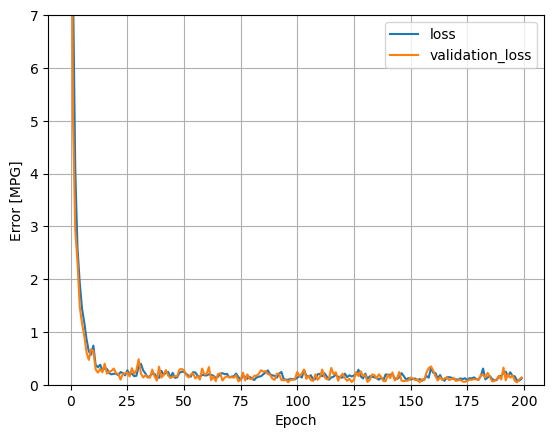

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='validation_loss')
    plt.ylim([0, 7])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    # plt.yscale()
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

7/7 [==============================] - 0s 2ms/step - loss: 0.1457
0.14566253125667572


Text(0, 0.5, 'True activity')

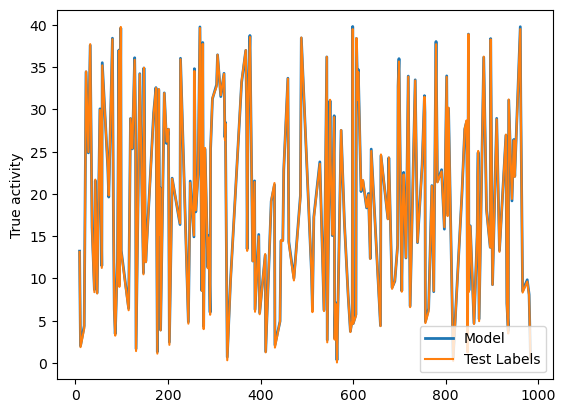

In [9]:
dnn_model.evaluate(df_test, test_labels, verbose=1)

x = tf.linspace(1, 20, 420)
y = dnn_model.predict(df_test)
test_result = dnn_model.evaluate(df_test, test_labels)
print(test_result)

plt.plot(list(test_labels.index), y, label = "Model", linewidth = 2)
plt.plot(list(test_labels.index), test_labels, label = "Test Labels")
plt.legend()
plt.ylabel("True activity")